# **Preprocessing feature set 1 data for use with the LSTM model**

Now we have analysed the time series data we can preprocess the data to use for our LSTM model.

This will involve deciding which features to keep/remove, detecting anomalies, imputation, scaling and placing into the 3D array required for an LSTM model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**01 - Feature removal**

The observed frequency rate for each feature is important as features that are sparsely sampled do not lend themselves to building time series of a 6 hour resolution.

As per the paper from Zeng et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9513908/#CR8), features that were observed less than 0.1 times in the 6 hour peroid will be excluded. This was coroborrated with Dr Murali.

Anything higher would likley restrict sufficient data coverage for meaningful analysis at this stage.

In [5]:
# Load the time series data for feature set 1
data_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/06_extracted_data_analysis/01_feature_set_1_analysis/patient_f1_data_feature_labels.parquet'
patient_data_df = pd.read_parquet(data_path)
patient_data_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start                       label  
0                   200.0        Inspired O2 Fraction  
1                   200.0     Tidal Volume (observed)  
2                   200.0  Tidal Volume (spontaneous)  
3                   200.0               Minute Volume  
4                   200.0         Peak Insp. Pressure

In [51]:
patient_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116601 entries, 0 to 116638
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   subject_id               116601 non-null  int64  
 1   itemid                   116601 non-null  int64  
 2   valuenum                 116601 non-null  float64
 3   time_to_extubation_mins  116601 non-null  float64
 4   time_from_window_start   116601 non-null  float64
 5   label                    116601 non-null  object 
dtypes: float64(3), int64(2), object(1)
memory usage: 6.2+ MB


In [7]:
# Load the average sampling frequency previously caluclated
freq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/06_extracted_data_analysis/01_feature_set_1_analysis/sampling_frequency.parquet'
freq_df = pd.read_parquet(freq_path)
freq_df

Feature  Average Sampling Frequency
0              Respiratory Rate                    6.614763
1   O2 saturation pulseoxymetry                    6.610508
2          Inspired O2 Fraction                    2.104446
3       Tidal Volume (observed)                    1.600298
4                 Minute Volume                    1.597532
5           Peak Insp. Pressure                    1.524144
6    Tidal Volume (spontaneous)                    1.367581
7               Ventilator Mode                    1.203999
8                 PH (Arterial)                    0.534567
9         Arterial CO2 Pressure                    0.524782
10         Arterial O2 pressure                    0.524782
11                   Hemoglobin                    0.247181
12                        EtCO2                    0.189109
13             Plateau Pressure                    0.159753
14         Negative Insp. Force                    0.008083

In [10]:
# Identify all features in the table that have a average sampling frequency < 0.1
freq_df[freq_df['Average Sampling Frequency'] < 0.1]

Feature  Average Sampling Frequency
14  Negative Insp. Force                    0.008083

Negative Insp. Force has an average sampling frequency of sugnificantly less than 0.1 times in the 6 hour window and will be removed.

In [12]:
# From the patient data remove all rows that relate to Negative Insp. Force
patient_data_df = patient_data_df[patient_data_df['label'] != 'Negative Insp. Force']
patient_data_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start                       label  
0                   200.0        Inspired O2 Fraction  
1                   200.0     Tidal Volume (observed)  
2                   200.0  Tidal Volume (spontaneous)  
3                   200.0               Minute Volume  
4                   200.0         Peak Insp. Pressure

In [15]:
# Check there are no entries of NIF remaining by printing the unique labels in a table
print(patient_data_df['label'].unique())

['Inspired O2 Fraction' 'Tidal Volume (observed)'
 'Tidal Volume (spontaneous)' 'Minute Volume' 'Peak Insp. Pressure'
 'EtCO2' 'Respiratory Rate' 'O2 saturation pulseoxymetry'
 'Ventilator Mode' 'Arterial O2 pressure' 'Arterial CO2 Pressure'
 'PH (Arterial)' 'Hemoglobin' 'Plateau Pressure']


In [20]:
# Save this for now in the drive
patient_data_df.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/patient_data_v01.parquet')

In [21]:
# Save this for now in the drive
patient_data_df.to_csv('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/patient_data_v01.csv')

**Addendum - Train / test split**

Now we have our final set of features we can split our data into the train and test set of patients prior to further data preprocessing.

For this study the train/test split will be 80/20 - in keeping with similar studies.


In [111]:
# Load patient data from the drive
patient_file = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/patient_data_v01.parquet'
patient_data_df = pd.read_parquet(patient_file)
patient_data_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start                       label  
0                   200.0        Inspired O2 Fraction  
1                   200.0     Tidal Volume (observed)  
2                   200.0  Tidal Volume (spontaneous)  
3                   200.0               Minute Volume  
4                   200.0         Peak Insp. Pressure

Next we need to attach the extubation failure labels to the data

In [113]:
# Attach the extubation_failure labels to the data

# Load annotated patient data
annotations_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/03_annotated_set/annotation_v03.parquet'
annotations_df = pd.read_parquet(annotations_path)
annotations_df.head()

subject_id   hadm_id   stay_id ventilation_starttime ventilation_endtime  \
0     10001884  26184834  37510196   2131-01-11 04:40:00 2131-01-12 17:40:00   
22    10002428  28662225  38875437   2156-04-19 20:10:00 2156-04-22 17:05:00   
29    10004235  24181354  34100191   2196-02-24 16:52:00 2196-02-27 16:28:00   
32    10004720  22081550  35009126   2186-11-12 20:29:00 2186-11-17 14:00:00   
33    10004733  27411876  39635619   2174-12-04 12:25:00 2174-12-07 16:20:00   

    ventilation_itemid ventilation_ordercategoryname extubation_starttime  \
0               225792                   Ventilation  2131-01-12 17:40:00   
22              225792                   Ventilation  2156-04-22 17:10:00   
29              225792                   Ventilation  2196-02-27 16:28:00   
32              225792                   Ventilation  2186-11-17 14:00:00   
33              225792                   Ventilation  2174-12-07 16:20:00   

    extubation_endtime  extubation_itemid extubation_ordercategoryname  \
0  2131-01-12 17:41:00             227194        Intubation/Extubation   
22 2156-04-22 17:11:00             227194        Intubation/Extubation   
29 2196-02-27 16:29:00             227194        Intubation/Extubation   
32 2186-11-17 14:01:00             227194        Intubation/Extubation   
33 2174-12-07 16:21:00             227194        Intubation/Extubation   

    ventilation_duration  anchor_age  extubation_failure  
0                 2220.0          68                   1  
22                4135.0          80                   0  
29                4296.0          47                   1  
32                6811.0          61                   1  
33                4555.0          51                   0

In [114]:
# Create a new column in the patient file for extubation_failure and match the annotation from annotation file
patient_data_df['extubation_failure'] = patient_data_df['subject_id'].map(annotations_df.set_index('subject_id')['extubation_failure'])
patient_data_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start                       label  extubation_failure  
0                   200.0        Inspired O2 Fraction                   1  
1                   200.0     Tidal Volume (observed)                   1  
2                   200.0  Tidal Volume (spontaneous)                   1  
3                   200.0               Minute Volume                   1  
4                   200.0         Peak Insp. Pressure                   1

In [115]:
patient_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116601 entries, 0 to 116638
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   subject_id               116601 non-null  int64  
 1   itemid                   116601 non-null  int64  
 2   valuenum                 116601 non-null  float64
 3   time_to_extubation_mins  116601 non-null  float64
 4   time_from_window_start   116601 non-null  float64
 5   label                    116601 non-null  object 
 6   extubation_failure       116601 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 7.1+ MB


In [116]:
# Split the data 80/20 by patient (subject_id)
unique_patients = patient_data_df['subject_id'].unique()

In [117]:
from sklearn.model_selection import train_test_split

# Split the patients into 80% train and 20% test
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

In [118]:
# Subset the original dataframe into train and test sets based on the split patient IDs
train_df = patient_data_df[patient_data_df['subject_id'].isin(train_patients)]
test_df = patient_data_df[patient_data_df['subject_id'].isin(test_patients)]

# Display the sizes of the splits
print(f"Total number of patients: {len(unique_patients)}")
print(f"Number of patients in train set: {len(train_patients)}")
print(f"Number of patients in test set: {len(test_patients)}")

# Verify the splits
print(f"Number of rows in original dataframe: {len(patient_data_df)}")
print(f"Number of rows in train dataframe: {len(train_df)}")
print(f"Number of rows in test dataframe: {len(test_df)}")

Total number of patients: 4701
Number of patients in train set: 3760
Number of patients in test set: 941
Number of rows in original dataframe: 116601
Number of rows in train dataframe: 93421
Number of rows in test dataframe: 23180


In [119]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93421 entries, 0 to 116559
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   subject_id               93421 non-null  int64  
 1   itemid                   93421 non-null  int64  
 2   valuenum                 93421 non-null  float64
 3   time_to_extubation_mins  93421 non-null  float64
 4   time_from_window_start   93421 non-null  float64
 5   label                    93421 non-null  object 
 6   extubation_failure       93421 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 5.7+ MB


**02 - Anomaly / outlier detection**

Outliers tend to skew the data such that some values could be ignored and others overemphasised.

These outliers need to be detected and handled to be within a reasonable range.

Importantly, the range needs to be set based on the training data and then applied to the test data.

In [120]:
# For each feature we can calculate statistics
train_feature_stats = train_df.groupby('label').agg({
    'valuenum': ['min', 'max', 'mean', 'median', 'std']
}).reset_index()

train_feature_stats

label valuenum                                \
                                     min       max        mean  median   
0         Arterial CO2 Pressure     16.0    108.00   41.033486   40.00   
1          Arterial O2 pressure     16.0    525.00  112.728564  106.00   
2                         EtCO2     19.0     75.00   37.730159   37.00   
3                    Hemoglobin      3.8     15.80    9.567462    9.40   
4          Inspired O2 Fraction      0.0    100.00   43.396515   40.00   
5                 Minute Volume      0.0    777.00    8.829290    8.40   
6   O2 saturation pulseoxymetry     10.0    100.00   97.575598   98.00   
7                 PH (Arterial)      6.8      7.58    7.411888    7.42   
8           Peak Insp. Pressure      0.0   2523.00   14.157914   12.00   
9              Plateau Pressure      0.0     39.00   18.280402   18.00   
10             Respiratory Rate      0.0   2325.00   19.097316   18.00   
11      Tidal Volume (observed)      0.0   2202.00  473.835419  453.00   
12   Tidal Volume (spontaneous)      0.0  60000.00  528.767831  449.00   
13              Ventilator Mode      1.0     71.00   18.668340   11.00   

                 
            std  
0      8.794605  
1     39.157535  
2      7.659719  
3      1.636077  
4     11.720480  
5     10.284782  
6      2.842284  
7      0.073777  
8     33.631360  
9      4.926320  
10    15.803900  
11   164.352196  
12  1345.568887  
13    14.157081

Note, ventiltor mode is a categorical variable. As such, outlier detection will not be carried out as each number represents a defined ventilator mode.

To identify outliers, we need to set a reasonable range from which we can then detect and remove outliers.

Helpfully, MIMIC provides high and low normal value ranges for several features in the chartevents table.

We will first extract these and filter out values that exceed these ranges and set them as NaN.

For any features that do not have recommended ranges, a standard range of mean +- 3 std dev will be used and values outside this range set to NaN.

In [25]:
# Load the d_items table
items_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/mimic-iv-2.2-raw-data/icu/d_items.csv'
items_df = pd.read_csv(items_path)
items_df.head()

itemid                    label        abbreviation         linksto  \
0  220001             Problem List        Problem List     chartevents   
1  220003       ICU Admission date  ICU Admission date  datetimeevents   
2  220045               Heart Rate                  HR     chartevents   
3  220046  Heart rate Alarm - High     HR Alarm - High     chartevents   
4  220047   Heart Rate Alarm - Low      HR Alarm - Low     chartevents   

              category unitname     param_type  lownormalvalue  \
0              General      NaN           Text             NaN   
1                  ADT      NaN  Date and time             NaN   
2  Routine Vital Signs      bpm        Numeric             NaN   
3               Alarms      bpm        Numeric             NaN   
4               Alarms      bpm        Numeric             NaN   

   highnormalvalue  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

The columns lownormalvalue and highnormal value provide expected values for a specific feature.

These, where present, will be used.

In [26]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemid           4014 non-null   int64  
 1   label            4014 non-null   object 
 2   abbreviation     4014 non-null   object 
 3   linksto          4014 non-null   object 
 4   category         4014 non-null   object 
 5   unitname         1108 non-null   object 
 6   param_type       4014 non-null   object 
 7   lownormalvalue   19 non-null     float64
 8   highnormalvalue  22 non-null     float64
dtypes: float64(2), int64(1), object(6)
memory usage: 282.4+ KB


In [68]:
# For the unique labels in the patient data, extract the lownormalvalue and highnormalvalue
mimic_ranges = pd.merge(patient_data_df, items_df, left_on='itemid', right_on='itemid', how='left')

# Remove the duplicate label_x and label_y column
mimic_ranges = mimic_ranges.drop(['label_y'], axis=1)

# Rename the label_x column to label
mimic_ranges = mimic_ranges.rename(columns={'label_x': 'label'})

mimic_ranges.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start                       label  \
0                   200.0        Inspired O2 Fraction   
1                   200.0     Tidal Volume (observed)   
2                   200.0  Tidal Volume (spontaneous)   
3                   200.0               Minute Volume   
4                   200.0         Peak Insp. Pressure   

                 abbreviation      linksto     category unitname param_type  \
0                        FiO2  chartevents  Respiratory      NaN    Numeric   
1     Tidal Volume (observed)  chartevents  Respiratory       mL    Numeric   
2  Tidal Volume (spontaneous)  chartevents  Respiratory       mL    Numeric   
3               Minute Volume  chartevents  Respiratory    L/min    Numeric   
4         Peak Insp. Pressure  chartevents  Respiratory    cmH2O    Numeric   

   lownormalvalue  highnormalvalue  
0             NaN              NaN  
1           299.0            750.0  
2           299.0            750.0  
3             NaN             12.1  
4             NaN              NaN

In [69]:
mimic_ranges = mimic_ranges[['label', 'itemid', 'lownormalvalue', 'highnormalvalue']]

# Remove duplicate itemid rows
mimic_ranges = mimic_ranges.drop_duplicates()

mimic_ranges

label  itemid  lownormalvalue  highnormalvalue
0           Inspired O2 Fraction  223835             NaN              NaN
1        Tidal Volume (observed)  224685           299.0            750.0
2     Tidal Volume (spontaneous)  224686           299.0            750.0
3                  Minute Volume  224687             NaN             12.1
4            Peak Insp. Pressure  224695             NaN              NaN
5                          EtCO2  228640             NaN              NaN
6               Respiratory Rate  220210             NaN              NaN
7    O2 saturation pulseoxymetry  220277             NaN              NaN
31               Ventilator Mode  223849             NaN              NaN
63          Arterial O2 pressure  220224             NaN              NaN
64         Arterial CO2 Pressure  220235             NaN              NaN
65                 PH (Arterial)  223830             NaN              NaN
87                    Hemoglobin  220228             NaN              NaN
258             Plateau Pressure  224696             NaN             31.0

The main paper (Zeng et al.) uses "Reasonable ranges" on the MIMIC data set in conjunction with critical care physicians.

First we will try the method of mean+/- 3 standard deviations for the high and low normal values inclusive of the MIMIC reccommended range and see what % of data points it removes.

In [140]:
# Where the value in mimic_range is null, replace it with the mean +/ 3 std
mimic_ranges_copy = mimic_ranges.copy()
train_feature_stats_copy = train_feature_stats.copy()

In [142]:
train_feature_stats_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (label, )           14 non-null     object 
 1   (valuenum, min)     14 non-null     float64
 2   (valuenum, max)     14 non-null     float64
 3   (valuenum, mean)    14 non-null     float64
 4   (valuenum, median)  14 non-null     float64
 5   (valuenum, std)     14 non-null     float64
dtypes: float64(5), object(1)
memory usage: 800.0+ bytes


In [143]:
train_feature_stats_copy.columns = ['_'.join(col).strip() for col in train_feature_stats_copy.columns.values]

In [145]:
train_feature_stats_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label_           14 non-null     object 
 1   valuenum_min     14 non-null     float64
 2   valuenum_max     14 non-null     float64
 3   valuenum_mean    14 non-null     float64
 4   valuenum_median  14 non-null     float64
 5   valuenum_std     14 non-null     float64
dtypes: float64(5), object(1)
memory usage: 800.0+ bytes


In [146]:
merged_ranges = pd.merge(mimic_ranges_copy, train_feature_stats_copy, left_on='label', right_on='label_')
merged_ranges.head()

label  itemid  lownormalvalue  highnormalvalue  \
0        Inspired O2 Fraction  223835             NaN              NaN   
1     Tidal Volume (observed)  224685           299.0            750.0   
2  Tidal Volume (spontaneous)  224686           299.0            750.0   
3               Minute Volume  224687             NaN             12.1   
4         Peak Insp. Pressure  224695             NaN              NaN   

                       label_  valuenum_min  valuenum_max  valuenum_mean  \
0        Inspired O2 Fraction           0.0         100.0      43.396515   
1     Tidal Volume (observed)           0.0        2202.0     473.835419   
2  Tidal Volume (spontaneous)           0.0       60000.0     528.767831   
3               Minute Volume           0.0         777.0       8.829290   
4         Peak Insp. Pressure           0.0        2523.0      14.157914   

   valuenum_median  valuenum_std  
0             40.0     11.720480  
1            453.0    164.352196  
2            449.0   1345.568887  
3              8.4     10.284782  
4             12.0     33.631360

In [147]:
# Create reasonable ranges
k = 3

# Update lownormalvalue and highnormalvalue
merged_ranges['lownormalvalue'] = merged_ranges.apply(
    lambda row: row['lownormalvalue'] if not pd.isna(row['lownormalvalue'])
    else max(row['valuenum_min'], row['valuenum_mean'] - k * row['valuenum_std']),
    axis=1
)

merged_ranges['highnormalvalue'] = merged_ranges.apply(
    lambda row: row['highnormalvalue'] if not pd.isna(row['highnormalvalue'])
    else min(row['valuenum_max'], row['valuenum_mean'] + k * row['valuenum_std']),
    axis=1
)

In [148]:
# Drop the extra columns
merged_train_ranges = merged_ranges[['label', 'itemid', 'lownormalvalue', 'highnormalvalue']]
merged_train_ranges

label  itemid  lownormalvalue  highnormalvalue
0          Inspired O2 Fraction  223835        8.235074        78.557955
1       Tidal Volume (observed)  224685      299.000000       750.000000
2    Tidal Volume (spontaneous)  224686      299.000000       750.000000
3                 Minute Volume  224687        0.000000        12.100000
4           Peak Insp. Pressure  224695        0.000000       115.051995
5                         EtCO2  228640       19.000000        60.709317
6              Respiratory Rate  220210        0.000000        66.509017
7   O2 saturation pulseoxymetry  220277       89.048745       100.000000
8               Ventilator Mode  223849        1.000000        61.139581
9          Arterial O2 pressure  220224       16.000000       230.201170
10        Arterial CO2 Pressure  220235       16.000000        67.417300
11                PH (Arterial)  223830        7.190558         7.580000
12                   Hemoglobin  220228        4.659232        14.475692
13             Plateau Pressure  224696        3.501443        31.000000

In [153]:
# Apply these ranges to both the train and test set
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [156]:
# Checking no rows have been lost
print(train_df_copy.shape[0])
print(test_df_copy.shape[0])

93421
23180


In [157]:
# Set outliers to NaN for later imputation

# Function to set outliers as NaN
def set_outliers_to_nan(df, mimic_df):
    for i, row in mimic_df.iterrows():
        if row['label'] != 'Ventilator Mode':  # Skip Ventilator Mode as it is categorical
            feature_mask = df['label'] == row['label']
            df.loc[feature_mask & ((df['valuenum'] < row['lownormalvalue']) | (df['valuenum'] > row['highnormalvalue'])), 'valuenum'] = np.nan
    return df

In [159]:
# Apply setting outliers to NaN
train_filtered_df = set_outliers_to_nan(train_df_copy, merged_train_ranges)
test_filtered_df = set_outliers_to_nan(test_df_copy, merged_train_ranges)

In [160]:
# Calculate the percentage of data points set to NaN

# Function to calculate the percentage of NaN values per feature
def calculate_nan_stats(df, label_col='label', value_col='valuenum'):
    stats = []
    for label in df[label_col].unique():
        feature_mask = df[label_col] == label
        total_points = feature_mask.sum()
        nan_points = df.loc[feature_mask, value_col].isna().sum()
        percentage_nan = (nan_points / total_points) * 100
        stats.append({
            'label': label,
            'total_data_points': total_points,
            'nan_data_points': nan_points,
            'percentage_nan': percentage_nan
        })
    return pd.DataFrame(stats)

In [162]:
train_nan_stats = calculate_nan_stats(train_filtered_df)
test_nan_stats = calculate_nan_stats(test_filtered_df)

# Print the results
print("Train set:")
train_nan_stats

Train set:


label  total_data_points  nan_data_points  \
0          Inspired O2 Fraction               7919              203   
1       Tidal Volume (observed)               6075              847   
2    Tidal Volume (spontaneous)               5157              828   
3                 Minute Volume               6025              631   
4           Peak Insp. Pressure               5743                1   
5                         EtCO2                693                7   
6              Respiratory Rate              24888                5   
7   O2 saturation pulseoxymetry              24875              245   
8               Ventilator Mode               4583                0   
9          Arterial O2 pressure               1971               26   
10        Arterial CO2 Pressure               1971               25   
11                PH (Arterial)               2002               35   
12                   Hemoglobin                922                6   
13             Plateau Pressure                597               12   

    percentage_nan  
0         2.563455  
1        13.942387  
2        16.055846  
3        10.473029  
4         0.017413  
5         1.010101  
6         0.020090  
7         0.984925  
8         0.000000  
9         1.319127  
10        1.268392  
11        1.748252  
12        0.650759  
13        2.010050

In [163]:
print("Test set:")
test_nan_stats

Test set:


label  total_data_points  nan_data_points  \
0          Inspired O2 Fraction               1974               58   
1           Peak Insp. Pressure               1422                0   
2       Tidal Volume (observed)               1448              207   
3    Tidal Volume (spontaneous)               1272              195   
4                 Minute Volume               1485              174   
5              Respiratory Rate               6208                0   
6   O2 saturation pulseoxymetry               6201               65   
7          Arterial O2 pressure                496                4   
8         Arterial CO2 Pressure                496                6   
9                 PH (Arterial)                511               12   
10              Ventilator Mode               1077                0   
11             Plateau Pressure                154                5   
12                   Hemoglobin                240                3   
13                        EtCO2                196                3   

    percentage_nan  
0         2.938197  
1         0.000000  
2        14.295580  
3        15.330189  
4        11.717172  
5         0.000000  
6         1.048218  
7         0.806452  
8         1.209677  
9         2.348337  
10        0.000000  
11        3.246753  
12        1.250000  
13        1.530612

In [164]:
# Calculate the percentage of data points removed in train set
total_data_points = len(train_df)
nan_data_points = train_filtered_df['valuenum'].isna().sum()
percentage_nan_overall = (nan_data_points / total_data_points) * 100

print(f"Percentage of NaN data in train set: {percentage_nan_overall:.2f}%")

Percentage of NaN data in train set: 3.07%


In [165]:
# Calculate the percentage of data points removed in test set
total_data_points = len(test_df)
nan_data_points = test_filtered_df['valuenum'].isna().sum()
percentage_nan_overall = (nan_data_points / total_data_points) * 100

print(f"Percentage of NaN data in test set: {percentage_nan_overall:.2f}%")

Percentage of NaN data in test set: 3.16%


Features with a larger percentage of points removed indicate a larger number of outliers.

This seems to be the case for tidal volume and Minute volume.

Possible explanations could be:

Physiological Variability:

- Tidal Volume (TV): This is the volume of air moved into or out of the lungs during normal breathing. There can be significant variability among individuals based on factors like lung capacity, respiratory health, activity level, and body size.

- Minute Volume (MV): This is the total volume of air breathed in one minute, which is a product of tidal volume and respiratory rate. Since it depends on two variables, it can exhibit even more variability.

Measurement Errors or Data Quality Issues:

- Instrument Calibration: Measurement devices might have calibration issues, leading to incorrect readings.
- Data Entry Errors: Manual data entry errors can lead to incorrect values being recorded.

Clinical Interventions:

- Ventilator Settings: Patients on mechanical ventilation can have widely varying tidal and minute volumes based on their clinical condition and the ventilator settings applied by healthcare providers.
- Therapeutic Changes: Changes in therapy, such as adjusting ventilator settings or administering certain medications, can cause abrupt changes in tidal and minute volumes.

Acute Conditions:

- Respiratory Diseases: Patients with conditions like ARDS (Acute Respiratory Distress Syndrome), COPD (Chronic Obstructive Pulmonary Disease), or other acute respiratory conditions can exhibit abnormal tidal and minute volumes.
- Acute Events: Sudden changes in a patient's condition, such as during a respiratory crisis, can lead to temporary but significant deviations from normal values.

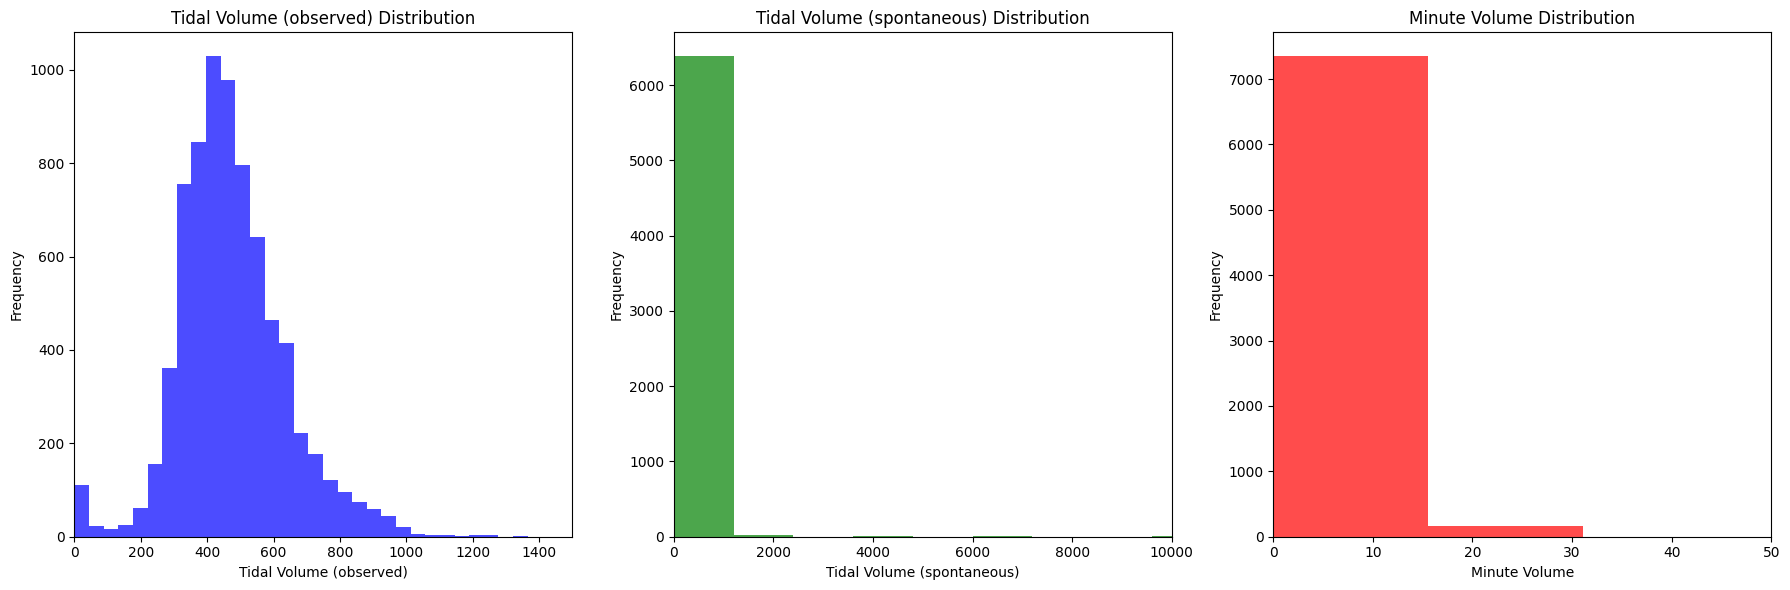

In [85]:
# Look at the distribution of Minute Volume and Tidal Volume from the original patient set
# Plotting histograms for Tidal Volume (observed), Tidal Volume (spontaneous), and Minute Volume
plt.figure(figsize=(18, 6))

# Tidal Volume (observed)
plt.subplot(1, 3, 1)
plt.hist(patient_data_df[patient_data_df['label'] == 'Tidal Volume (observed)']['valuenum'], bins=50, color='blue', alpha=0.7)
plt.title('Tidal Volume (observed) Distribution')
plt.xlabel('Tidal Volume (observed)')
plt.ylabel('Frequency')
plt.xlim(0, 1500)

# Tidal Volume (spontaneous)
plt.subplot(1, 3, 2)
plt.hist(patient_data_df[patient_data_df['label'] == 'Tidal Volume (spontaneous)']['valuenum'], bins=50, color='green', alpha=0.7)
plt.title('Tidal Volume (spontaneous) Distribution')
plt.xlabel('Tidal Volume (spontaneous)')
plt.ylabel('Frequency')
plt.xlim(0, 10000)

# Minute Volume
plt.subplot(1, 3, 3)
plt.hist(patient_data_df[patient_data_df['label'] == 'Minute Volume']['valuenum'], bins=50, color='red', alpha=0.7)
plt.title('Minute Volume Distribution')
plt.xlabel('Minute Volume')
plt.ylabel('Frequency')
plt.xlim(0, 50)

plt.tight_layout()
plt.show()

Nonetheless, this data will be saved and used for further pre-processing as filtering did not lead to a significant amount of data loss (approx. 3%)

In [166]:
train_filtered_df
test_filtered_df

subject_id  itemid  valuenum  time_to_extubation_mins  \
0         10001884  223835     40.00                    160.0   
1         10001884  224685       NaN                    160.0   
2         10001884  224686       NaN                    160.0   
3         10001884  224687      6.10                    160.0   
4         10001884  224695     17.00                    160.0   
...            ...     ...       ...                      ...   
116555    17912822  220235     39.00                    252.0   
116556    17912822  223830      7.45                    252.0   
116557    17912822  220224    158.00                     17.0   
116558    17912822  220235     35.00                     17.0   
116559    17912822  223830      7.47                     17.0   

        time_from_window_start                       label  extubation_failure  
0                        200.0        Inspired O2 Fraction                   1  
1                        200.0     Tidal Volume (observed)                   1  
2                        200.0  Tidal Volume (spontaneous)                   1  
3                        200.0               Minute Volume                   1  
4                        200.0         Peak Insp. Pressure                   1  
...                        ...                         ...                 ...  
116555                   108.0       Arterial CO2 Pressure                   0  
116556                   108.0               PH (Arterial)                   0  
116557                   343.0        Arterial O2 pressure                   0  
116558                   343.0       Arterial CO2 Pressure                   0  
116559                   343.0               PH (Arterial)                   0  

[93421 rows x 7 columns]

**Missing value imputation**

The NaN values need to be imputed.

Logic will be as follows:
- If the value has a preceeding measurement for that patient then a simple forward fill will be used

- Otherwise if the value has cannot be filled forward then the mean value across all patients within an hour of the time to window start will be taken

In [87]:
# Define a function to forward fill any NaNs with a preceding value for that patient
def forward_fill(df):
    df = df.sort_values(by=['subject_id', 'label', 'time_from_window_start'])
    df['valuenum'] = df.groupby(['subject_id', 'label'])['valuenum'].ffill()
    return df

In [167]:
train_filtered_df_copy = train_filtered_df.copy()
test_filtered_df_copy = test_filtered_df.copy()

In [168]:
# Apply the forward fill to both train and test set separately
train_filtered_df_copy = forward_fill(train_filtered_df_copy)
test_filtered_df_copy = forward_fill(test_filtered_df_copy)

In [170]:
# Count the number of data points that are no longer NaN compared to before
diff = train_filtered_df['valuenum'].isna().sum() - train_filtered_df_copy['valuenum'].isna().sum()
print(f"Number of data points filled: {diff}")


Number of data points filled: 1025


In [171]:
# Repeat for the test set
diff = test_filtered_df['valuenum'].isna().sum() - test_filtered_df_copy['valuenum'].isna().sum()
print(f"Number of data points filled: {diff}")

Number of data points filled: 230


In [173]:
# Function to perform mean imputation within an hour window
def mean_impute_within_hour(df, ref_df, time_col='time_from_window_start', value_col='valuenum', label_col='label', time_window=60):
    for i, row in df.iterrows():
        if pd.isna(row[value_col]):
            label_df = ref_df[ref_df[label_col] == row[label_col]]
            mean_value = label_df[
                (label_df[time_col] >= (row[time_col] - time_window)) &
                (label_df[time_col] <= (row[time_col] + time_window))
            ][value_col].mean()
            df.at[i, value_col] = mean_value
    return df

Use train_df for mean reference to avoid data leakage for the test set

In [175]:
# Apply mean imputation within hour window separately to train and test set
train_filtered_df_copy = mean_impute_within_hour(train_filtered_df_copy, train_filtered_df_copy)
test_filtered_df_copy = mean_impute_within_hour(test_filtered_df_copy, train_filtered_df_copy)

In [176]:
# Count the number of data points that are no longer NaN compared to before
diff = train_filtered_df['valuenum'].isna().sum() - train_filtered_df_copy['valuenum'].isna().sum()
print(f"Number of data points filled: {diff}")

Number of data points filled: 2871


In [177]:
# Repeat for test data
diff = test_filtered_df['valuenum'].isna().sum() - test_filtered_df_copy['valuenum'].isna().sum()
print(f"Number of data points filled: {diff}")

Number of data points filled: 732


In [180]:
# Check there are no NaN values left
train_filtered_df_copy.isna().sum()

subject_id                 0
itemid                     0
valuenum                   0
time_to_extubation_mins    0
time_from_window_start     0
label                      0
extubation_failure         0
dtype: int64

In [181]:
test_filtered_df_copy.isna().sum()

subject_id                 0
itemid                     0
valuenum                   0
time_to_extubation_mins    0
time_from_window_start     0
label                      0
extubation_failure         0
dtype: int64

Now all the NaN values have been filled we can see how the data looks.

In [182]:
# Save the train and test data for further use
train_filtered_df_copy.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/train_test_sets/feature_1_train_set.parquet')
test_filtered_df_copy.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/train_test_sets/feature_1_test_set.parquet')

Let's check that the imputations have not significantly swayed the data.

In [183]:
imputed_stats = train_filtered_df_copy.groupby('label').agg({
    'valuenum': ['min', 'max', 'mean', 'median', 'std']
}).reset_index()

imputed_stats

label valuenum                                  \
                                     min         max        mean  median   
0         Arterial CO2 Pressure     16.0   67.000000   40.592069   40.00   
1          Arterial O2 pressure     16.0  228.000000  110.217475  105.00   
2                         EtCO2     19.0   58.000000   37.409044   37.00   
3                    Hemoglobin      5.6   14.300000    9.543333    9.40   
4          Inspired O2 Fraction     21.0   75.000000   42.172141   40.00   
5                 Minute Volume      0.0   12.100000    8.154957    8.30   
6   O2 saturation pulseoxymetry     90.0  100.000000   97.701734   98.00   
7                 PH (Arterial)      7.2    7.580000    7.416366    7.42   
8           Peak Insp. Pressure      0.0   46.000000   13.723124   12.00   
9              Plateau Pressure      5.0   31.000000   18.072454   18.00   
10             Respiratory Rate      0.0   66.000000   18.999277   18.00   
11      Tidal Volume (observed)    299.0  750.000000  476.485029  472.00   
12   Tidal Volume (spontaneous)    299.0  778.696516  476.528866  475.00   
13              Ventilator Mode      1.0   71.000000   18.668340   11.00   

                
           std  
0     7.698236  
1    30.365845  
2     6.910412  
3     1.569966  
4     7.982246  
5     1.981561  
6     2.242465  
7     0.062218  
8     5.892344  
9     4.293001  
10    5.978753  
11  105.392225  
12  106.119534  
13   14.157081

In [184]:
# Compare imputed stats to previous feature stats
comparison_df = pd.merge(train_feature_stats, imputed_stats, on='label', suffixes=('_before', '_after'))

# Calculate the differences
comparison_df['min_diff'] = comparison_df[('valuenum_after', 'min')] - comparison_df[('valuenum_before', 'min')]
comparison_df['max_diff'] = comparison_df[('valuenum_after', 'max')] - comparison_df[('valuenum_before', 'max')]
comparison_df['mean_diff'] = comparison_df[('valuenum_after', 'mean')] - comparison_df[('valuenum_before', 'mean')]
comparison_df['median_diff'] = comparison_df[('valuenum_after', 'median')] - comparison_df[('valuenum_before', 'median')]
comparison_df['std_diff'] = comparison_df[('valuenum_after', 'std')] - comparison_df[('valuenum_before', 'std')]

# Select the relevant columns for display
diff_columns = ['label', 'min_diff', 'max_diff', 'mean_diff', 'median_diff', 'std_diff']
comparison_diff_df = comparison_df[diff_columns]

comparison_diff_df

<ipython-input-184-a6917a35782f>:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  comparison_df = pd.merge(train_feature_stats, imputed_stats, on='label', suffixes=('_before', '_after'))


label min_diff      max_diff  mean_diff median_diff  \
                                                                                
0         Arterial CO2 Pressure      0.0    -41.000000  -0.441416         0.0   
1          Arterial O2 pressure      0.0   -297.000000  -2.511090        -1.0   
2                         EtCO2      0.0    -17.000000  -0.321115         0.0   
3                    Hemoglobin      1.8     -1.500000  -0.024129         0.0   
4          Inspired O2 Fraction     21.0    -25.000000  -1.224374         0.0   
5                 Minute Volume      0.0   -764.900000  -0.674332        -0.1   
6   O2 saturation pulseoxymetry     80.0      0.000000   0.126136         0.0   
7                 PH (Arterial)      0.4      0.000000   0.004478         0.0   
8           Peak Insp. Pressure      0.0  -2477.000000  -0.434790         0.0   
9              Plateau Pressure      5.0     -8.000000  -0.207948         0.0   
10             Respiratory Rate      0.0  -2259.000000  -0.098039         0.0   
11      Tidal Volume (observed)    299.0  -1452.000000   2.649610        19.0   
12   Tidal Volume (spontaneous)    299.0 -59221.303484 -52.238965        26.0   
13              Ventilator Mode      0.0      0.000000   0.000000         0.0   

        std_diff  
                  
0  -1.096369e+00  
1  -8.791690e+00  
2  -7.493070e-01  
3  -6.611056e-02  
4  -3.738234e+00  
5  -8.303220e+00  
6  -5.998192e-01  
7  -1.155892e-02  
8  -2.773902e+01  
9  -6.333191e-01  
10 -9.825147e+00  
11 -5.895997e+01  
12 -1.239449e+03  
13  3.552714e-15

Overall very small changes in the features.

Tidal Volume clearly had a large outlier skewing the mean hence the large difference.

We can now proceed with formatting the data for the relevant models.